In [36]:
import os
import wrf
import math
import cmaps
import time
import datetime
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [37]:
def read_decoded_dat(pawr):
    dtype=np.dtype('>f') ### big endian float
    # dtype=np.dtype('<f') ### little endian float

    vread=np.fromfile(pawr,dtype=dtype)

    vlon_radar=vread[1]
    vlat_radar=vread[4]
    vz_radar=vread[7]
    print('==============================')
    print('[pawr radar info]')
    print('radar_site_lon: ',vlon_radar)
    print('radar_site_lat: ',vlat_radar)
    print('radar_site_hgt: ',vz_radar)

    nrec=7     # nrec=8 ### radar-4d
    ioffset=9

    ndata=int((len(vread)-ioffset)/(nrec+2))
    print('radar_data_num: ',ndata)

    vdata=np.zeros(shape=(ndata,nrec))

    for i in range(ndata):
        ista=i*(nrec+2)+1+ioffset
        iend=i*(nrec+2)+nrec+1+ioffset
        vdata[i,:]=vread[ista:iend]

    print('------------------------------')
    print('pawr[*,0] = obs variable')
    print('pawr[*,1] = longitude')
    print('pawr[*,2] = latitude')
    print('pawr[*,3] = altitude')
    print('pawr[*,4] = obs value')
    print('pawr[*,5] = obs error std')
    print('pawr[*,6] = obs type')
    print('==============================')

    return vdata

def read_wrf_latlon(ifile):
 
    ncObj = nc.Dataset(ifile,'r',format='NETCDF3_CLASSIC')

    lat = ncObj.variables['XLAT_M'][:]
    lon = ncObj.variables['XLONG_M'][:]

    ncObj.close()
    return  lat, lon

def write_cross_data3(outfile,time_s,LEVEL,nlat,nlon,grid_lat,grid_lon,ext_var,ext_var2):

    #---define dimensions
    ncfile = nc.Dataset(outfile,'w',format='NETCDF4')    
    ncfile.createDimension('south_north',nlat)
    ncfile.createDimension('west_east',nlon)
    ncfile.createDimension('lev',len(LEVEL))
    ncfile.createDimension('time',1)
    # ncfile.createDimension('DateStrLen',None)
    
    #---define variables
    ncfile.createVariable('Times','f4',('time'))
    ncfile.createVariable('lev','i4',('lev'))
    ncfile.createVariable('lat','f4',('south_north','west_east'))
    ncfile.createVariable('lon','f4',('south_north','west_east'))
    ncfile.createVariable('dbz','i4',('time','lev','south_north','west_east'))
    ncfile.createVariable('maxdbz','i4',('time','south_north','west_east'))

    #---assign values
    lev = LEVEL
    ncfile.variables['Times'][0] = unix_time(time_s)
    ncfile.variables['lev'][:] = lev
    ncfile.variables['lon'][:,:] = grid_lon
    ncfile.variables['lat'][:,:] = grid_lat
    ncfile.variables['dbz'][0,:,:,:] = ext_var
    ncfile.variables['maxdbz'][0,:,:] = ext_var2

    ncfile.variables['Times'].description = "seconds since 1970-01-01 00:00:00"
    ncfile.variables['Times'].units = 's'
    ncfile.variables['lev'].description = "height"
    ncfile.variables['lev'].units = "m"
    ncfile.variables['lat'].description = "latitude"
    ncfile.variables['lat'].units = "degrees_north"
    ncfile.variables['lon'].description = "longitude"
    ncfile.variables['lon'].units = "degrees_east"
    ncfile.variables['dbz'].description = 'cappi dbz'
    ncfile.variables['dbz'].units = 'dBZ'
    ncfile.variables['dbz'].description = 'Max dbz'
    ncfile.variables['dbz'].units = 'dBZ'
    
    #---close ncfile
    ncfile.close()

def unix_time(dt):
    # 转换成时间数组
    timeArray = time.strptime(dt, "%Y%m%d%H%M%S")
    # 转换成时间戳
    timestamp = int(time.mktime(timeArray))
    return timestamp


20210730060030
2021073006
LEVEL =  [  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000]
[pawr radar info]
radar_site_lon:  139.60898
radar_site_lat:  35.8615
radar_site_hgt:  29.3
radar_data_num:  833639
------------------------------
pawr[*,0] = obs variable
pawr[*,1] = longitude
pawr[*,2] = latitude
pawr[*,3] = altitude
pawr[*,4] = obs value
pawr[*,5] = obs error std
pawr[*,6] = obs type
[0, 33369, 69147, 105327, 141726, 178329, 215100, 252043, 289204, 326648, 364676, 403281, 442416, 482165, 522050, 562282, 602384, 642329, 682071, 721596, 760486, 798106, 833639]
35778


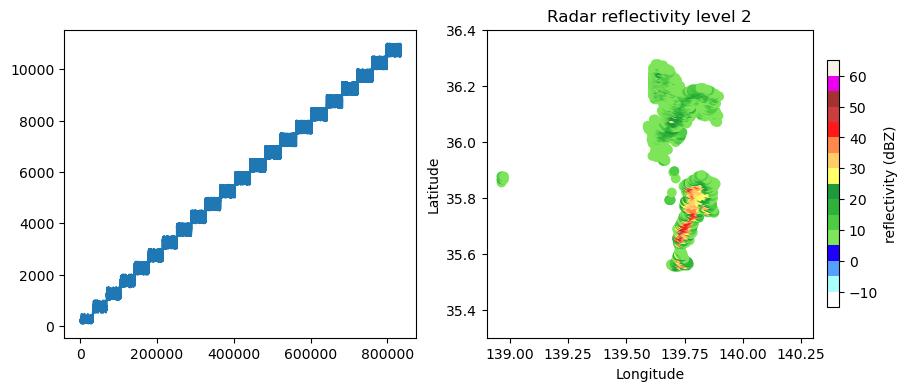

In [38]:
pawr = '/data/ra000007/zhaoyang/data/scale_database/scale-letkf-test-suite/obs/PAWR_Saitama/radar_20210730060030.dat'
bin_path,filename = os.path.split(pawr)
time_string  = filename.split(".")[0].split("_")[1]
time_date = time_string[0:10]
print(time_string)
print(time_date)
LEVEL = np.arange(500, 11100, 500)
print('LEVEL = ', LEVEL)

# 读取pawr雷达数据
pawr = read_decoded_dat(pawr)
# 将晴空区域反射率设置为0
fillvalue = 0.1
pawr[:,4][pawr[:,4] < 1] = fillvalue
pawr[:,4] = [10 * np.log10(num) for num in pawr[:,4]]
# pawr数据为~500高度间隔自500-11000m, 判断每个高度的数据index
lev_ind = [0]
for i in range(1,len(pawr[:,2])):
    if(pawr[i,2]-pawr[i-1,2]<-0.5):
        lev_ind.append(i)
lev_ind.append(len(pawr[:,2]))
print(lev_ind)


# import matplotlib
# import matplotlib.pyplot as plt

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# ax1.plot(pawr[:,3])


# lev = 2
# print(lev_ind[lev]-lev_ind[lev-1])
# lon_lev = pawr[lev_ind[lev-1]:lev_ind[lev],1]
# lat_lev = pawr[lev_ind[lev-1]:lev_ind[lev],2]
# val_lev = pawr[lev_ind[lev-1]:lev_ind[lev],4]

# lon_lev, lat_lev, val_lev = zip(*((i,j,k) for i,j,k in \
#                         zip(lon_lev,lat_lev,val_lev) if (k>5) ))

# cmap=cmaps.prcp_1
# levels= matplotlib.ticker.MaxNLocator(nbins=16).tick_values(-15,65)
# norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
# shadow = ax2.scatter(lon_lev, lat_lev, c=val_lev, cmap=cmap, norm=norm)
# ax2.set_xlabel('Longitude')
# ax2.set_ylabel('Latitude')
# ax2.set_xlim(138.9, 140.3)
# ax2.set_ylim(35.3, 36.4)
# ax2.set_title('Radar reflectivity level '+str(lev))

# cb = plt.colorbar(shadow, fraction=0.035, pad=0.04)
# cb.set_label('reflectivity (dBZ)')




(22, 255, 255)
500 m --- 1000 m --- 1500 m --- 2000 m --- 2500 m --- 3000 m --- 3500 m --- 4000 m --- 4500 m --- 5000 m --- 5500 m --- 6000 m --- 6500 m --- 7000 m --- 7500 m --- 8000 m --- 8500 m --- 9000 m --- 9500 m --- 10000 m --- 10500 m --- 11000 m --- 

/tmp/ipykernel_2324409/1579065665.py:70: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon1[0,:,:],lat1[0,:,:],maxdbz[:,:], cmap=cmap, norm=norm,)


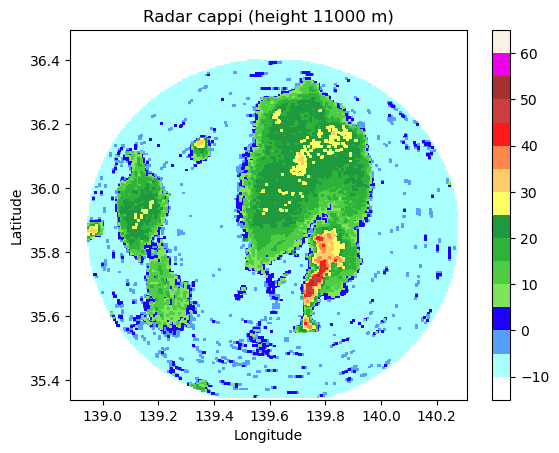

In [39]:
geo = '/data/ra000007/zhaoyang/postprocess/jp_pawr/data/GEJPTK_geogile/geo_em.d04.nc'

# 读取geo文件，提取模式网格
lat1,lon1 = read_wrf_latlon(geo)
nlat = np.shape(lat1)
nlon = np.shape(lon1)
nlev = len(LEVEL)
cappi = np.zeros((nlev, nlat[1], nlat[2]),dtype=float)
print(np.shape(cappi))

interp_mtd = 1

if interp_mtd == 1:
    for il in range(nlev):
        print(str(LEVEL[il]),'m ---',end=' ')
        cappi_ref=[]
        cappi_ref = np.copy(pawr[lev_ind[il]:lev_ind[il+1],:])
        # print('data from ',lev_ind[il],' ~ ',lev_ind[il+1])


        points = np.zeros([len(cappi_ref),2])
        points[:,0]=cappi_ref[:,2]
        points[:,1]=cappi_ref[:,1]

        interp_data_3d = griddata( points, cappi_ref[:,4], (lat1, lon1), method='linear')
        interp_data = np.copy(interp_data_3d[0,:,:])
        
    
        interp_data[ np.isnan(interp_data) ] = -999
        mask = np.where(interp_data < -10, 1, 0)
        mask1 = np.where(interp_data == 1, 1, 0)
        # interp_data[ mask == 1 ] = -999
        interp_data[ mask1 == 1 ] = 0
        interp_data_new = np.copy(interp_data)

        neighbor_index=1
        for i in range(neighbor_index,np.shape(interp_data)[0]-neighbor_index):
            for j in range(neighbor_index,np.shape(interp_data)[1]-neighbor_index):
                # if np.isnan(interp_data_new[i,j]):
                neighbors=[]
                neighbors = np.array(neighbors)
                for ii in range(i-neighbor_index,i+neighbor_index):
                    for jj in range(j-neighbor_index,j+neighbor_index):
                        if (interp_data[ii,jj]>-999):
                            neighbors=np.append(neighbors,interp_data[ii,jj])
                if(len(neighbors)>0):
                    interp_data_new[i,j] = np.max(neighbors)
        cappi[il,:,:] = interp_data_new[:,:]
                    

        # cmap=cmaps.prcp_1
        # levels= matplotlib.ticker.MaxNLocator(nbins=16).tick_values(-15,65)
        # norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
        # plt.pcolormesh(lon1[0,:,:],lat1[0,:,:],interp_data_new[:,:], cmap=cmap, norm=norm,)
        # plt.colorbar()#fraction=0.035, pad=0.04)
        # plt.xlabel('Longitude')
        # plt.ylabel('Latitude')
        # # plt.xlim(138.9, 140.3)
        # # plt.ylim(35.3, 36.4)
        # plt.title('Radar cappi (height '+str(LEVEL[il])+' m)')
        # plt.show()

        

    maxdbz = np.amax(cappi, axis=0)

    # cmap=cmaps.prcp_1
    # levels= matplotlib.ticker.MaxNLocator(nbins=16).tick_values(-15,65)
    # norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
    # plt.pcolormesh(lon1[0,:,:],lat1[0,:,:],maxdbz[:,:], cmap=cmap, norm=norm,)
    # plt.colorbar()#fraction=0.035, pad=0.04)
    # plt.xlabel('Longitude')
    # plt.ylabel('Latitude')
    # # plt.xlim(138.9, 140.3)
    # # plt.ylim(35.3, 36.4)
    # plt.title('Radar cappi (height '+str(LEVEL[il])+' m)')
    # plt.show()



In [40]:
lev = np.array([500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,7000,8000,9000,10000,12000,14000,15500,17000,19000])
print(lev)
print(LEVEL)

dir_out = "/data/ra000007/zhaoyang/postprocess/jp_pawr/data/cappi/data_d04/%s" %(time_date)
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
fileout = os.path.join(dir_out, "cappi_d04_dbz_%s.nc") %(time_string)
print(fileout)
write_cross_data3(fileout,time_string,LEVEL,nlat[1],nlon[2],lat1[0,:,:],lon1[0,:,:],cappi,maxdbz)

[  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  7000  8000  9000 10000 12000 14000 15500 17000 19000]
[  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000]
/data/ra000007/zhaoyang/postprocess/jp_pawr/data/cappi/data_d04/2021073006/cappi_d04_dbz_20210730060030.nc
